In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

clients = pd.read_csv("synthetic_clients.csv")

# Vérification rapide
clients.info()
clients.describe()
clients["Customer_Loyalty_Index_v2"] = (
    (clients["Purchase_Frequency"] * clients["Years_As_Client"]) /
    (1 + np.sqrt(clients["Payment_Delay_Days"]))
).round(2)

# Normalisation
num_cols = ["Annual_Sales", "Purchase_Frequency", "Average_Order_Value", "Discount_Rate", 
            "Product_Diversity", "Payment_Delay_Days", "Years_As_Client", "Customer_Loyalty_Index_v2"]

scaler = StandardScaler()
clients_scaled = pd.DataFrame(scaler.fit_transform(clients[num_cols]), columns=num_cols)

# Encodage de la région
encoder = OneHotEncoder(drop="first")
region_encoded = encoder.fit_transform(clients[["Region"]]).toarray()
region_labels = encoder.get_feature_names_out(["Region"])
region_df = pd.DataFrame(region_encoded, columns=region_labels)

clients_final = pd.concat([clients_scaled, region_df], axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Client_ID               1000 non-null   object 
 1   Region                  1000 non-null   object 
 2   Annual_Sales            1000 non-null   int64  
 3   Purchase_Frequency      1000 non-null   int64  
 4   Average_Order_Value     1000 non-null   int64  
 5   Discount_Rate           1000 non-null   float64
 6   Product_Diversity       1000 non-null   int64  
 7   Payment_Delay_Days      1000 non-null   int64  
 8   Years_As_Client         1000 non-null   int64  
 9   Customer_Loyalty_Index  1000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 78.3+ KB


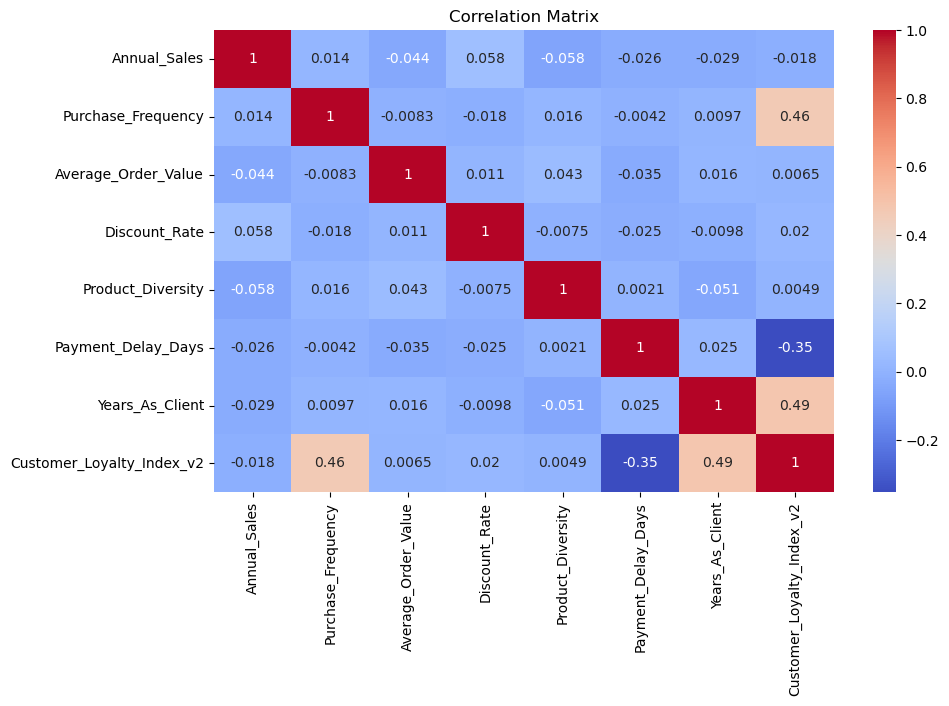

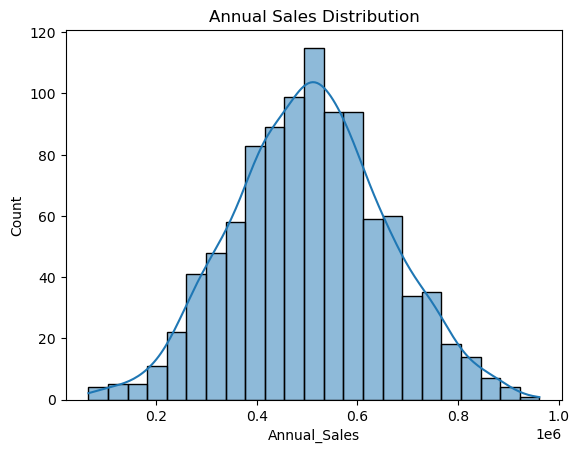

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap des corrélations
plt.figure(figsize=(10,6))
sns.heatmap(clients[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Distribution des ventes
sns.histplot(clients["Annual_Sales"], kde=True)
plt.title("Annual Sales Distribution")
plt.show()


C:\Users\wvg9824\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\wvg9824\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\wvg9824\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\wvg9824\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:14

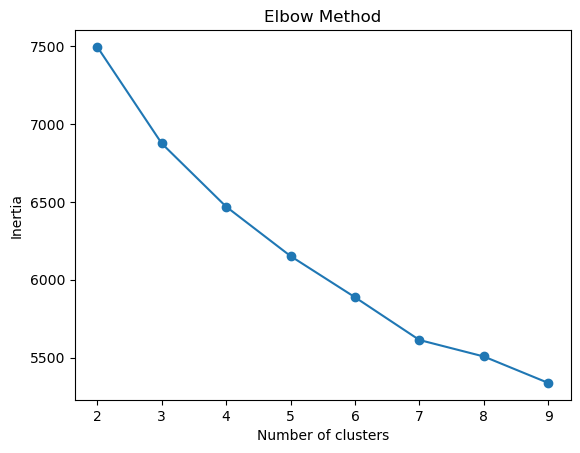

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clients_final)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()


In [21]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clients["Cluster"] = kmeans.fit_predict(clients_final)


C:\Users\wvg9824\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,Annual_Sales,Purchase_Frequency,Average_Order_Value,Discount_Rate,Product_Diversity,Payment_Delay_Days,Years_As_Client,Customer_Loyalty_Index_v2,Annual_Sales
Cluster,,,,,,,,,
0,514332.51,40.62,10784.86,0.07,6.44,32.52,4.23,28.11,514332.51
1,434390.97,37.89,12829.02,0.09,11.75,40.15,10.77,55.91,434390.97
2,499416.66,60.78,12564.55,0.13,9.68,13.96,10.98,173.25,499416.66
3,585081.52,31.64,12431.54,0.19,6.44,31.46,8.13,42.23,585081.52
4,504558.72,43.18,12481.58,0.15,15.07,23.82,3.92,31.12,504558.72


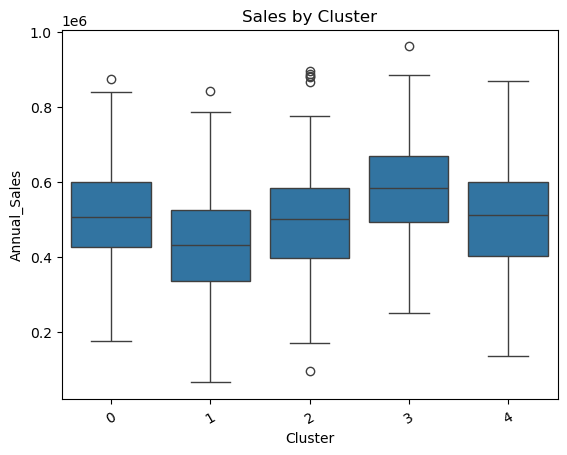

In [22]:
# Profil moyen par cluster
cluster_profile = clients.groupby("Cluster")[num_cols + ["Annual_Sales"]].mean().round(2)
display(cluster_profile)


# Visualisation
sns.boxplot(x="Cluster", y="Annual_Sales", data=clients)
plt.xticks(rotation=30)
plt.title("Sales by Cluster")
plt.show()
